## Problem Statement

To identify the better model between Logistic Regression and Naive Bayes, based on their accuracies in classifying reddit posts into two categories, namely "iOS Programming" subreddit and "Developing Android Apps" subreddit.

## Executive Summary

Reddit posts were scraped from two subreddit threads, "iOS Programming" and "Developing Android Apps". These reddit posts were then pre-processed before being separately trained on the Logistic Regression and the Multinomial Naive Bayes classifier. Initially, before feature engineering was performed, the Logistic Regression algorithm outperformed the Multinomial Naive Bayes algorithm. However, after feature engineering was performed, in which the selftext and title of each posts were merged, the Multinomial Naive Bayes algorithm outperformed the Logistic Regression.

### Contents:
- [Import libraries](#Import-libraries)
- [Import data](#Import-data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modeling](#Modeling)
- [Further Modeling](#Further-Modeling)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import regex as re

from bs4 import BeautifulSoup
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords # Import the stop word list

import imp
plotting_util = imp.load_source('plotting_util', './plotting_utilities.py')
from plotting_util import Plotter
plotter = Plotter()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package wordnet to /home/dev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/dev/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import data

In [2]:
android_df = pd.read_csv('../data/android_dev.csv')
android_df.drop(['Unnamed: 0'], axis=1, inplace=True)
android_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,num_crossposts,media,is_video,post_hint,preview,link_flair_template_id,crosspost_parent_list,crosspost_parent,media_metadata,author_cakeday
0,NaN,androiddev,Looking for Android developers? Heard about a ...,t2_6l4z3,False,NaN,0,False,"Weekly ""who's hiring"" thread!",[],...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,androiddev,This thread is for simple questions that don't...,t2_6l4z3,False,NaN,0,False,"Weekly Questions Thread - January 20, 2020",[],...,0,NaN,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN
2,NaN,androiddev,NaN,t2_iassk,False,NaN,0,False,Telegram-like theme switching with reveal anim...,"[{'e': 'text', 't': 'Article'}]",...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,254cc416-e885-11e4-b88d-22000bc18061,NaN,NaN,NaN,NaN
3,NaN,androiddev,NaN,t2_3vf8x,False,NaN,0,False,The Power of Types for Errors,[],...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN
4,NaN,androiddev,NaN,t2_45tfbxxq,False,NaN,0,False,Everything you need to know about Memory Leaks...,[],...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN


In [3]:
ios_df = pd.read_csv('../data/ios_programming.csv')
ios_df.drop(['Unnamed: 0'], axis=1, inplace=True)
ios_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,crosspost_parent_list,crosspost_parent,media_metadata,author_cakeday
0,NaN,iOSProgramming,Welcome to r/iOSProgramming! Click the links b...,t2_3h859,False,NaN,0,False,READ BEFORE POSTING / Megathread Hub,"[{'e': 'text', 't': 'Announcement'}]",...,https://www.reddit.com/r/iOSProgramming/commen...,66427,1.578431e+09,0,NaN,False,NaN,NaN,NaN,NaN
1,NaN,iOSProgramming,Welcome to the weekly r/iOSProgramming simple ...,t2_6l4z3,False,NaN,0,False,"Simple Questions Megathread—January 13, 2020","[{'e': 'text', 't': 'Weekly'}]",...,https://www.reddit.com/r/iOSProgramming/commen...,66427,1.578946e+09,0,NaN,False,NaN,NaN,NaN,NaN
2,NaN,iOSProgramming,NaN,t2_dw88zzd,False,NaN,0,False,Pull to Refresh in SwiftUI,"[{'e': 'text', 't': 'Article'}]",...,https://link.medium.com/1QgLlY4ho3,66427,1.579486e+09,0,NaN,False,NaN,NaN,NaN,NaN
3,NaN,iOSProgramming,Keeping up with the newest frameworks and tool...,t2_3hizc4vt,False,NaN,0,False,Developer's Guide to Common Vulnerabilities an...,"[{'e': 'text', 't': 'Article'}]",...,https://www.reddit.com/r/iOSProgramming/commen...,66427,1.579524e+09,0,NaN,False,NaN,NaN,NaN,NaN
4,NaN,iOSProgramming,People tell me there are 10x more web jobs tha...,t2_kgbts,False,NaN,0,False,Is there a shortage of iOS Developers?,"[{'e': 'text', 't': 'Question'}]",...,https://www.reddit.com/r/iOSProgramming/commen...,66427,1.579452e+09,0,NaN,False,NaN,NaN,NaN,NaN


In [4]:
combined_df = pd.concat([android_df, ios_df], sort=False)
combined_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,num_crossposts,media,is_video,post_hint,preview,link_flair_template_id,crosspost_parent_list,crosspost_parent,media_metadata,author_cakeday
0,NaN,androiddev,Looking for Android developers? Heard about a ...,t2_6l4z3,False,NaN,0,False,"Weekly ""who's hiring"" thread!",[],...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,androiddev,This thread is for simple questions that don't...,t2_6l4z3,False,NaN,0,False,"Weekly Questions Thread - January 20, 2020",[],...,0,NaN,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN
2,NaN,androiddev,NaN,t2_iassk,False,NaN,0,False,Telegram-like theme switching with reveal anim...,"[{'e': 'text', 't': 'Article'}]",...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,254cc416-e885-11e4-b88d-22000bc18061,NaN,NaN,NaN,NaN
3,NaN,androiddev,NaN,t2_3vf8x,False,NaN,0,False,The Power of Types for Errors,[],...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN
4,NaN,androiddev,NaN,t2_45tfbxxq,False,NaN,0,False,Everything you need to know about Memory Leaks...,[],...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN


## Pre-processing

In [5]:
combined_df.isnull().sum()

approved_at_utc           1978
subreddit                    0
selftext                   531
author_fullname              6
saved                        0
                          ... 
link_flair_template_id    1023
crosspost_parent_list     1936
crosspost_parent          1936
media_metadata            1899
author_cakeday            1973
Length: 109, dtype: int64

In [6]:
combined_df['author_flair_type'].value_counts()

text        1865
richtext     107
Name: author_flair_type, dtype: int64

In [7]:
combined_df['link_flair_type'].value_counts()

richtext    1075
text         903
Name: link_flair_type, dtype: int64

In [8]:
combined_df['subreddit'] = combined_df['subreddit'].map({'androiddev': 1, 'iOSProgramming': 0})

In [9]:
combined_df = combined_df[['id', 'title', 'name', 'media', 
                           'is_video', 'permalink', 'author_flair_type',
                           'link_flair_type', 'created', 'created_utc', 'selftext',
                           'author_fullname', 'subreddit']]

## Exploratory Data Analysis

In [10]:
df_1 = combined_df.copy()

In [11]:
df_1.dropna(subset=['selftext'], inplace=True)

In [12]:
# Import lemmatizer
lemmatizer = WordNetLemmatizer()

def review_to_words(raw_post):
    # Function to convert a raw reddit post to a string of words
    # The input is a single string (a raw reddit post), and 
    # the output is a single string (a preprocessed reddit post)
    
    # 1. Remove HTML.
    post_text = BeautifulSoup(raw_post).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    letters_only = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', letters_only)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Lemmatize words
    lemmatized_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

**Android**

In [13]:
df_1_android = df_1.loc[df_1['subreddit'] == 1]

In [14]:
df_1_android['selftext'] = df_1_android['selftext'].apply(review_to_words)

In [15]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_1_android['selftext'])

len_features = len(cvec.get_feature_names())
print('Number of features: {}'.format(len_features))

df_1_android_cv = pd.DataFrame(cvec.transform(df_1_android['selftext']).todense(),columns=cvec.get_feature_names())

top_android = df_1_android_cv.sum(axis=0)
top_android.sort_values(ascending = False).head(20)

Number of features: 6596


app        910
android    805
https      519
com        484
google     348
apps       282
use        254
like       251
using      234
new        234
java       218
play       207
know       202
want       179
code       179
store      172
make       159
user       155
way        155
need       141
dtype: int64

In [16]:
df_top_android = top_android.to_frame(name='count')
df_top_android['word'] = df_top_android.index
df_top_android.reset_index(drop=True, inplace=True)
df_top_android['freq'] = df_top_android['count'] / len(df_1_android)

cols = ['word','count','freq']
df_top_android = df_top_android[cols]
df_top_android.sort_values(by='count',ascending=False, inplace=True)
df_top_android.head(10)

,word,count,freq
309,app,910,1.256906
247,android,805,1.111878
2804,https,519,0.716851
1066,com,484,0.668508
2560,google,348,0.480663
353,apps,282,0.389503
6247,use,254,0.350829
3380,like,251,0.346685
6263,using,234,0.323204
3915,new,234,0.323204


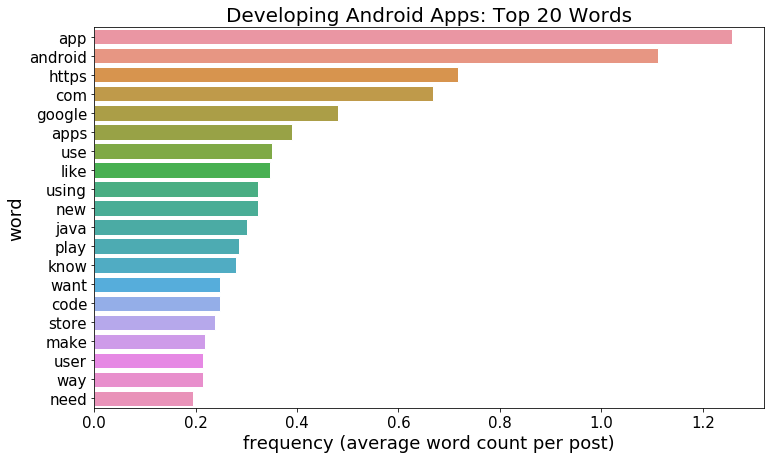

In [17]:
plotter.plot_horizontal_barchart("Developing Android Apps: Top 20 Words", df_top_android)
plt.savefig('../images/barchart_top20words_android.png', transparent=True)

**iOS**

In [18]:
df_1_ios = df_1.loc[df_1['subreddit'] == 0]

In [19]:
df_1_ios['selftext'] = df_1_ios['selftext'].apply(review_to_words)

In [20]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_1_ios['selftext'])

len_features = len(cvec.get_feature_names())
print('Number of features: {}'.format(len_features))

df_1_ios_cv = pd.DataFrame(cvec.transform(df_1_ios['selftext']).todense(),columns=cvec.get_feature_names())

top_ios = df_1_ios_cv.sum(axis=0)
top_ios.sort_values(ascending = False).head(20)

Number of features: 6407


app          833
https        395
com          370
ios          356
like         277
view         268
use          245
apple        238
let          227
using        223
time         219
code         212
data         190
want         189
swift        185
know         180
help         167
new          162
xcode        156
developer    151
dtype: int64

In [21]:
df_top_ios = top_ios.to_frame(name='count')
df_top_ios['word'] = df_top_ios.index
df_top_ios.reset_index(drop=True, inplace=True)
df_top_ios['freq'] = df_top_ios['count'] / len(df_1_ios)

cols = ['word','count','freq']
df_top_ios = df_top_ios[cols]
df_top_ios.sort_values(by='count',ascending=False, inplace=True)
df_top_ios.head(10)

,word,count,freq
264,app,833,1.152144
2612,https,395,0.546335
1003,com,370,0.511757
2895,ios,356,0.492393
3170,like,277,0.383126
6158,view,268,0.370678
6057,use,245,0.338866
276,apple,238,0.329184
3147,let,227,0.313970
6080,using,223,0.308437


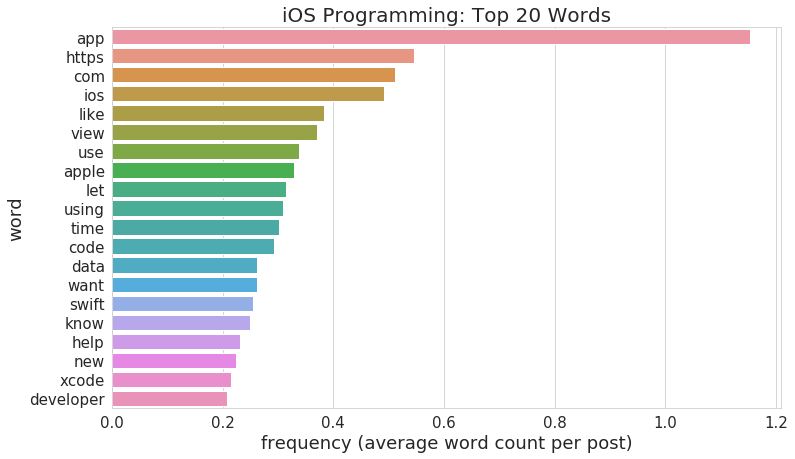

In [22]:
plotter.plot_horizontal_barchart("iOS Programming: Top 20 Words", df_top_ios)
plt.savefig('../images/barchart_top20words_ios.png', transparent=True)

## Modeling

### Baseline Accuracy

In [23]:
df_1['subreddit'].value_counts(normalize=True)

1    0.500346
0    0.499654
Name: subreddit, dtype: float64

In [24]:
X = df_1['selftext'].apply(review_to_words)
y = df_1['subreddit']

In [25]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size = 0.25,
                                                    random_state = 42)

### Multinomial Naive Bayes

In [26]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB())
])

In [27]:
pipe_params = {
#     'cvec__tokenizer': [lemmatizer.lemmatize, p_stemmer.stem],
    'cvec__max_features': [2500, 3000, 3500, 4000, 4500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=-1)
gs.fit(X_train, y_train) # gs.fit(X_train['selftext'], y_train)
print(gs.best_score_)
gs.best_params_

0.8341164047076108


{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

**Inference**

In [28]:
# Probabilities for positive class
pos_class_prob_sorted = gs.best_estimator_.named_steps['nb'].feature_log_prob_[0, :].argsort()

# Probabilities for negative class
neg_class_prob_sorted = gs.best_estimator_.named_steps['nb'].feature_log_prob_[1, :].argsort()

In [29]:
# Getting the top features 
pos_top_features = np.take(gs.best_estimator_.named_steps['cvec'].get_feature_names(), pos_class_prob_sorted)
neg_top_features = np.take(gs.best_estimator_.named_steps['cvec'].get_feature_names(), neg_class_prob_sorted)

In [30]:
# Top 20 features for the positive class
pos_top_features[:20].tolist()

['zip',
 'repeat',
 'replies top',
 'report rule',
 'drawable',
 'res',
 'respond questions',
 'discouraged',
 'retrofit',
 'room',
 'developing android',
 'rule breakers',
 'developers must',
 'runnable',
 'developer android',
 'russian',
 'rxjava',
 'samsung',
 'settext',
 'cut spam']

In [31]:
# Top 20 features for the negative class
neg_top_features[:20].tolist()

['uiviewcontroller',
 'beginner question',
 'beginner faq',
 'currentlocation',
 'play wwdc',
 'url google',
 'custom url',
 'battery level',
 'throws try',
 'basics useful',
 'basics storyboards',
 'beginner tutorials',
 'nil',
 'sean',
 'baseurl search',
 'nil let',
 'make sense',
 'datatask',
 'isempty',
 'makes easy']

**Classification Metrics**

In [32]:
gs.score(X_train, y_train) 

0.967741935483871

In [33]:
gs.score(X_test, y_test)

0.8370165745856354

In [34]:
predictions = gs.predict(X_test)

In [35]:
confusion_matrix(y_test, predictions)

array([[148,  33],
       [ 26, 155]])

In [36]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [37]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 148
False Positives: 33
False Negatives: 26
True Positives: 155


In [38]:
def get_classification_metrics(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    misclassification = 1 - accuracy
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    print("Accuracy: %s" % accuracy)
    print("Misclassification: %s" % misclassification)
    print("Sensitivity: %s" % sensitivity)
    print("Specificity: %s" % specificity)
    print("Precision: %s" % precision)

In [39]:
get_classification_metrics(tn, fp, fn, tp)

Accuracy: 0.8370165745856354
Misclassification: 0.1629834254143646
Sensitivity: 0.856353591160221
Specificity: 0.8176795580110497
Precision: 0.824468085106383


In [40]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': pred_proba})

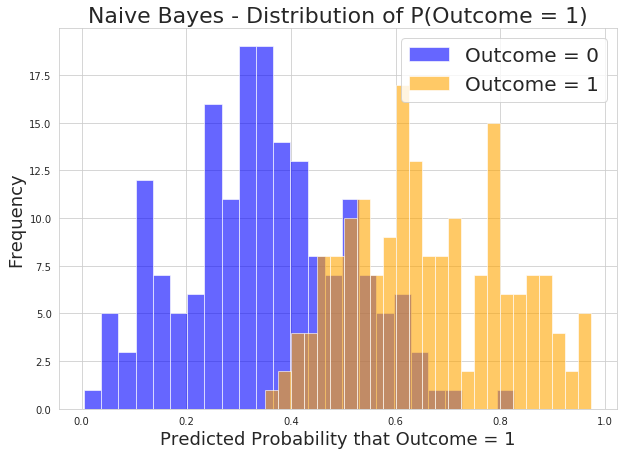

In [41]:
plotter.plot_probability_distribution(pred_df, "Naive Bayes")
plt.savefig('../images/probdist_naivebayes_before.png', transparent=True)

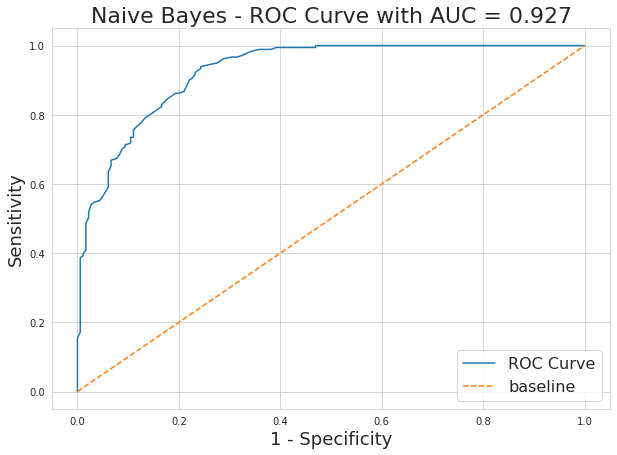

In [42]:
plotter.plot_roc_curve(pred_df=pred_df, classifier_name="Naive Bayes")
plt.savefig('../images/roc_naivebayes_before.png', transparent=True)

### Logistic Regression

In [43]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(max_iter=5000))
])

In [44]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 4000, 4500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2']
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8525453645745653


{'cvec__max_df': 0.9,
 'cvec__max_features': 3500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'lr__penalty': 'l2'}

**Inference**

In [45]:
selected_features = gs.best_estimator_.named_steps['cvec'].get_feature_names()

In [46]:
selected_features_coefs_exp = np.exp(gs.best_estimator_.named_steps['lr'].coef_[0])

In [47]:
sorted(list(zip(selected_features, selected_features_coefs_exp)), key=lambda tup: tup[1], reverse=True)[:10]

[('android', 141.42390774520368),
 ('google', 12.311125823574496),
 ('java', 5.649570053254163),
 ('play', 4.73395530642475),
 ('kotlin', 4.247201325882667),
 ('admob', 3.7896362933767516),
 ('activity', 3.638461988810392),
 ('play store', 3.0140925850172406),
 ('fragment', 2.906289124376091),
 ('studio', 2.7353629859675133)]

A unit change in the tf-idf score of the word "android" results in an approximately 141 times increase in likelihood of the post belong the subreddit "Developing Android Apps"

**Classification Metrics**

In [48]:
gs.score(X_train, y_train)

0.9834101382488479

In [49]:
gs.score(X_test, y_test)

0.8480662983425414

In [50]:
predictions = gs.predict(X_test)

In [51]:
confusion_matrix(y_test, predictions)

array([[157,  24],
       [ 31, 150]])

In [52]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [53]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 157
False Positives: 24
False Negatives: 31
True Positives: 150


In [54]:
get_classification_metrics(tn, fp, fn, tp)

Accuracy: 0.8480662983425414
Misclassification: 0.15193370165745856
Sensitivity: 0.8287292817679558
Specificity: 0.8674033149171271
Precision: 0.8620689655172413


In [55]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

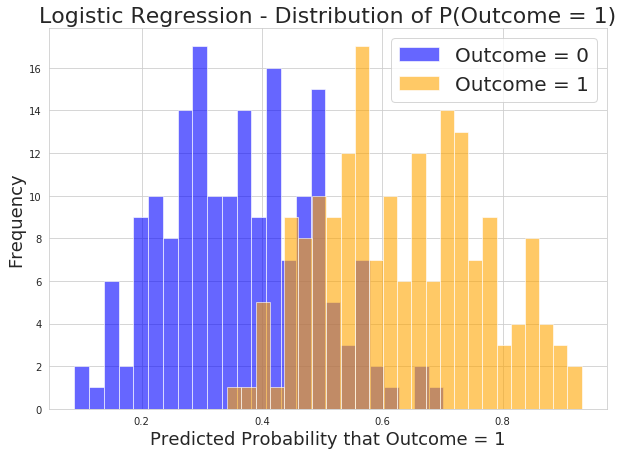

In [56]:
plotter.plot_probability_distribution(pred_df, "Logistic Regression")
plt.savefig('../images/probdist_logreg_before.png', transparent=True)

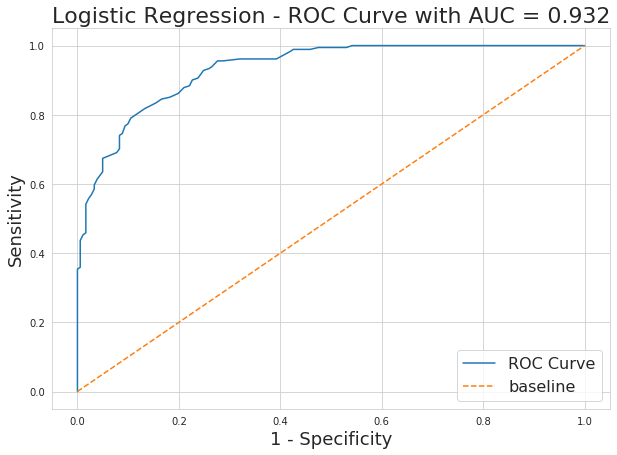

In [57]:
plotter.plot_roc_curve(pred_df=pred_df, classifier_name="Logistic Regression")
plt.savefig('../images/roc_logreg_before.png', transparent=True)

## Further Modeling

### Feature Engineering

In [58]:
df_2 = combined_df.copy()

In [59]:
df_2[['title', 'selftext']].isnull().sum()

title         0
selftext    531
dtype: int64

Since there is no null value in the title variable, we convert null values in the selftext variable to empty strings.

In [60]:
df_2['content'] = df_2['title'] + " " + df_2['selftext'].fillna('')

### Baseline Accuracy

In [61]:
df_2['subreddit'].value_counts(normalize=True)

0    0.504044
1    0.495956
Name: subreddit, dtype: float64

In [62]:
df_2.columns

Index(['id', 'title', 'name', 'media', 'is_video', 'permalink',
       'author_flair_type', 'link_flair_type', 'created', 'created_utc',
       'selftext', 'author_fullname', 'subreddit', 'content'],
      dtype='object')

In [63]:
X = df_2['content'].apply(review_to_words)
y = df_2['subreddit']

In [64]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size = 0.25,
                                                    random_state = 42)

### Multinomial Naive Bayes

In [65]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB())
])

In [66]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 4000, 4500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=-1)
gs.fit(X_train, y_train) # gs.fit(X_train['selftext'], y_train)
print(gs.best_score_)
gs.best_params_

0.8705366757998337


{'cvec__max_df': 0.9,
 'cvec__max_features': 3500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

**Inference**

In [67]:
# Probabilities for positive class
pos_class_prob_sorted = gs.best_estimator_.named_steps['nb'].feature_log_prob_[0, :].argsort()

# Probabilities for negative class
neg_class_prob_sorted = gs.best_estimator_.named_steps['nb'].feature_log_prob_[1, :].argsort()

In [68]:
# Getting the top features 
pos_top_features = np.take(gs.best_estimator_.named_steps['cvec'].get_feature_names(), pos_class_prob_sorted)
neg_top_features = np.take(gs.best_estimator_.named_steps['cvec'].get_feature_names(), neg_class_prob_sorted)

In [69]:
# Top 20 features for the positive class
pos_top_features[:20].tolist()

['java https',
 'espresso tests',
 'targeting api',
 'proguard',
 'breakers thank',
 'breakers',
 'programmatically change',
 'team small',
 'examples questions',
 'bottom navigation',
 'boot',
 'telegram',
 'telling',
 'posting examples',
 'possible programmatically',
 'espresso',
 'possible get',
 'blogs',
 'explorer',
 'extends']

In [70]:
# Top 20 features for the negative class
neg_top_features[:20].tolist()

['running courses',
 'required exp',
 'december welcome',
 'decode',
 'testable',
 'renew',
 'degrees',
 'testflight',
 'background color',
 'text moving',
 'delegation',
 'delete app',
 'textfield',
 'rendered',
 'deleted recommended',
 'texture',
 'reloaddata',
 'released first',
 'detect app',
 'redesign']

**Classification Metrics**

In [71]:
gs.score(X_train, y_train) 

0.9642616318273769

In [72]:
gs.score(X_test, y_test)

0.8848484848484849

In [73]:
predictions = gs.predict(X_test)

In [74]:
confusion_matrix(y_test, predictions)

array([[231,  19],
       [ 38, 207]])

In [75]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [76]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 231
False Positives: 19
False Negatives: 38
True Positives: 207


In [77]:
def get_classification_metrics(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    misclassification = 1 - accuracy
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    print("Accuracy: %s" % accuracy)
    print("Misclassification: %s" % misclassification)
    print("Sensitivity: %s" % sensitivity)
    print("Specificity: %s" % specificity)
    print("Precision: %s" % precision)

In [78]:
get_classification_metrics(tn, fp, fn, tp)

Accuracy: 0.8848484848484849
Misclassification: 0.11515151515151512
Sensitivity: 0.8448979591836735
Specificity: 0.924
Precision: 0.915929203539823


In [79]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': pred_proba})

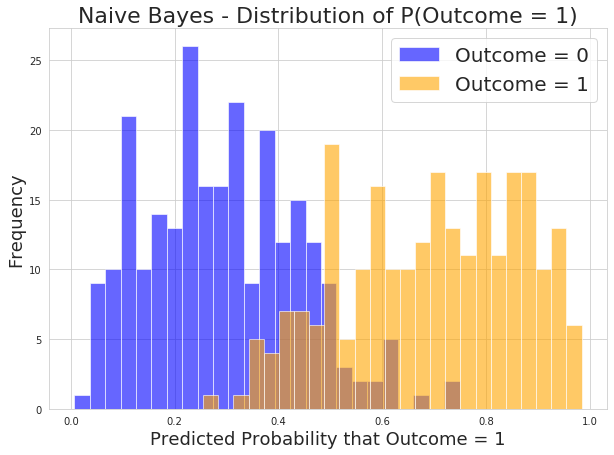

In [80]:
plotter.plot_probability_distribution(pred_df, "Naive Bayes")
plt.savefig('../images/probdist_naivebayes_after.png', transparent=True)

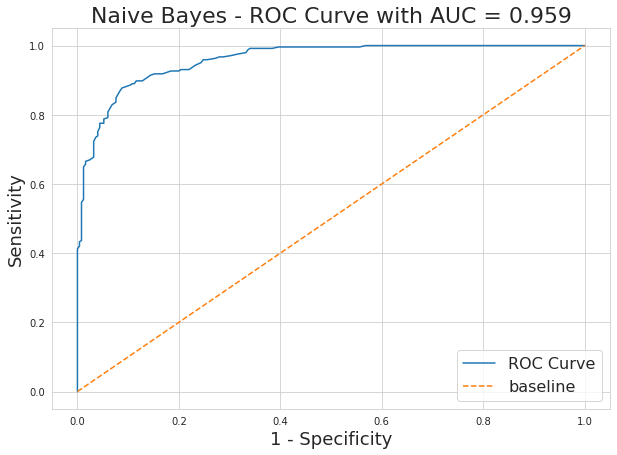

In [81]:
plotter.plot_roc_curve(pred_df=pred_df, classifier_name="Naive Bayes")
plt.savefig('../images/roc_naivebayes_after.png', transparent=True)

### Logistic Regression

In [82]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(max_iter=5000))
])

In [83]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 4000, 4500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8813151760520181


{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

**Inference**

In [84]:
selected_features = gs.best_estimator_.named_steps['cvec'].get_feature_names()

In [85]:
selected_features_coefs_exp = np.exp(gs.best_estimator_.named_steps['lr'].coef_[0])

In [86]:
sorted(list(zip(selected_features, selected_features_coefs_exp)), key=lambda tup: tup[1], reverse=True)[:10]

[('android', 897.8417116276675),
 ('google', 16.770670203212305),
 ('kotlin', 10.088019100991524),
 ('java', 7.372037874881025),
 ('admob', 6.014253449371238),
 ('play', 5.541065721593819),
 ('emulator', 3.801426649142562),
 ('activity', 3.567422719104193),
 ('play store', 3.5541578276332797),
 ('room', 3.4307103759156985)]

A unit change in the tf-idf score of the word "android" results in an approximately 898 times increase in likelihood of the post belong the subreddit "Developing Android Apps"

**Classification Metrics**

In [87]:
gs.score(X_train, y_train)

0.973701955495617

In [88]:
gs.score(X_test, y_test)

0.8767676767676768

In [89]:
predictions = gs.predict(X_test)

In [90]:
confusion_matrix(y_test, predictions)

array([[228,  22],
       [ 39, 206]])

In [91]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [92]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 228
False Positives: 22
False Negatives: 39
True Positives: 206


In [93]:
get_classification_metrics(tn, fp, fn, tp)

Accuracy: 0.8767676767676768
Misclassification: 0.12323232323232325
Sensitivity: 0.8408163265306122
Specificity: 0.912
Precision: 0.9035087719298246


In [94]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

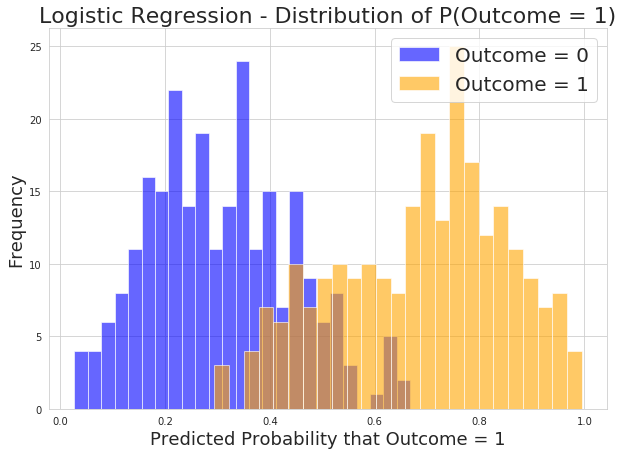

In [95]:
plotter.plot_probability_distribution(pred_df, "Logistic Regression")
plt.savefig('../images/probdist_logreg_after.png', transparent=True)

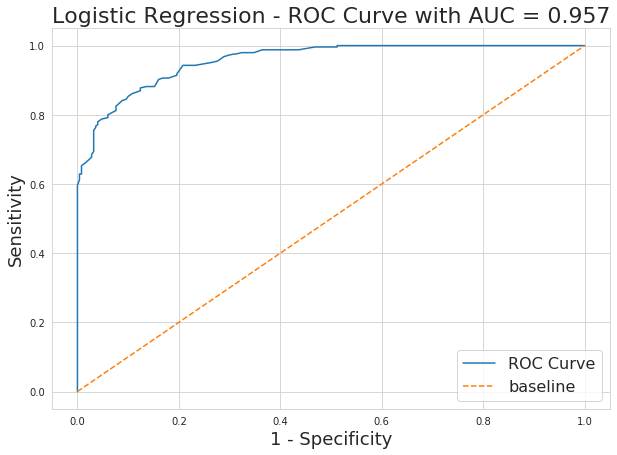

In [96]:
plotter.plot_roc_curve(pred_df=pred_df, classifier_name="Logistic Regression")
plt.savefig('../images/roc_logreg_after.png', transparent=True)

## Conclusions and Recommendations

The classification metrics of the models used are as follows:

<table>
    <thead>
        <tr>
            <th></th>
            <th colspan=2>Before Feature Engineering</th>
            <th colspan=2>After Feature Engineering</th>
        </tr>
        <tr>
            <th>Metrics</th>
            <th>Naive Bayes</th>
            <th>Logistic Regression</th>
            <th>Naive Bayes</th>
            <th>Logistic Regression</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Accuracy</td>
            <td>0.837</td>
            <td>0.848</td>
            <td>0.885</td>
            <td>0.877</td>
        </tr>
        <tr>
            <td>Misclassification</td>
            <td>0.163</td>
            <td>0.152</td>
            <td>0.115</td>
            <td>0.123</td>
        </tr>
        <tr>
            <td>Sensitivity</td>
            <td>0.856</td>
            <td>0.829</td>
            <td>0.845</td>
            <td>0.841</td>
        </tr>
        <tr>
            <td>Specificity</td>
            <td>0.818</td>
            <td>0.867</td>
            <td>0.924</td>
            <td>0.912</td>
        </tr>
        <tr>
            <td>Precision</td>
            <td>0.824</td>
            <td>0.862</td>
            <td>0.916</td>
            <td>0.904</td>
        </tr>
    </tbody>
</table>

It can be observed that the accuracy of the Logistic Regression classifier was higher than the accuracy of the Naive Bayes classifier before feature engineering was performed.

After feature engineering was performed, where the title and selftext was added together, the Naive Bayes classifier outperformed the Logistic Regression classifier in terms of accuracy.

Based on these findings, it is recommended that the title and selftext are both factored into the Naive Bayes classifier for the highest classification accuracy when classifying reddit posts as either of the two subreddit threads, "Developing Android Apps" and "iOS Programming".